# Regression and DNN Model 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pydot
import time
import datetime
import os

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [26]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import kerastuner as kt
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error


print(tf.__version__)

2.4.1


# Get Dataset

In [9]:

dir_p = r'C:\Users\Honeyz\Desktop\Aessa\THE_SIS\PyroDataProcessed.csv'
raw_dataset = pd.read_csv(dir_p, skipinitialspace=True)

dataset = raw_dataset.copy()
dataset = dataset.dropna()
dataset

,C% Biomass,H% Biomass,O% Biomass,N% Biomass,C% HDPE,H% HDPE,O% HDPE,N% HDPE,C% PS,H% PS,O% PS,N% PS,Time,Rate,Ratio,Temp,Oil%,Char%,Gas%
0,63.85,8.6,3.74,0.33,85.72,14.28,0,0.0,0.0,0.0,0.0,0,0.5,5,66.7,500,60.156065,10.936392,28.907543
1,63.85,8.6,3.74,0.33,85.72,14.28,0,0.0,0.0,0.0,0.0,0,0.5,5,100.0,500,56.000000,0.000000,44.000000
2,63.85,8.6,3.74,0.33,85.72,14.28,0,0.0,0.0,0.0,0.0,0,0.5,5,50.0,500,45.993999,17.313035,36.692966
3,63.85,8.6,3.74,0.33,85.72,14.28,0,0.0,0.0,0.0,0.0,0,0.5,5,33.3,500,44.038082,23.267154,32.694764
4,63.85,8.6,3.74,0.33,85.72,14.28,0,0.0,0.0,0.0,0.0,0,0.5,5,0.0,500,25.762381,34.435228,39.802391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,58.00,6.3,34.00,2.40,0.00,0.00,0,0.0,91.0,8.8,0.3,0,30.0,100,60.0,550,16.633680,15.340660,13.907280
243,58.00,6.3,34.00,2.40,0.00,0.00,0,0.0,91.0,8.8,0.3,0,30.0,100,61.5,550,15.999231,14.779844,13.749581
244,58.00,6.3,34.00,2.40,0.00,0.00,0,0.0,91.0,8.8,0.3,0,30.0,100,63.0,550,15.349117,14.221099,13.605475
245,58.00,6.3,34.00,2.40,0.00,0.00,0,0.0,91.0,8.8,0.3,0,30.0,100,64.5,550,14.683338,13.664426,13.474963


# Check Null values

In [4]:
#The dataset contains a few unknown values.
dataset.isna().sum()

C% Biomass    0
H% Biomass    0
O% Biomass    0
N% Biomass    0
C% HDPE       0
H% HDPE       0
O% HDPE       0
N% HDPE       0
C% PS         0
H% PS         0
O% PS         0
N% PS         0
Time          0
Rate          0
Ratio         0
Temp          0
Oil%          0
Char%         0
Gas%          0
dtype: int64

In [15]:
#Drop those rows to keep this initial tutorial simple.
#dataset = dataset.dropna()

# Splitting Data to training and testing data

In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=0)


test_dataset = dataset.drop(train_dataset.index)



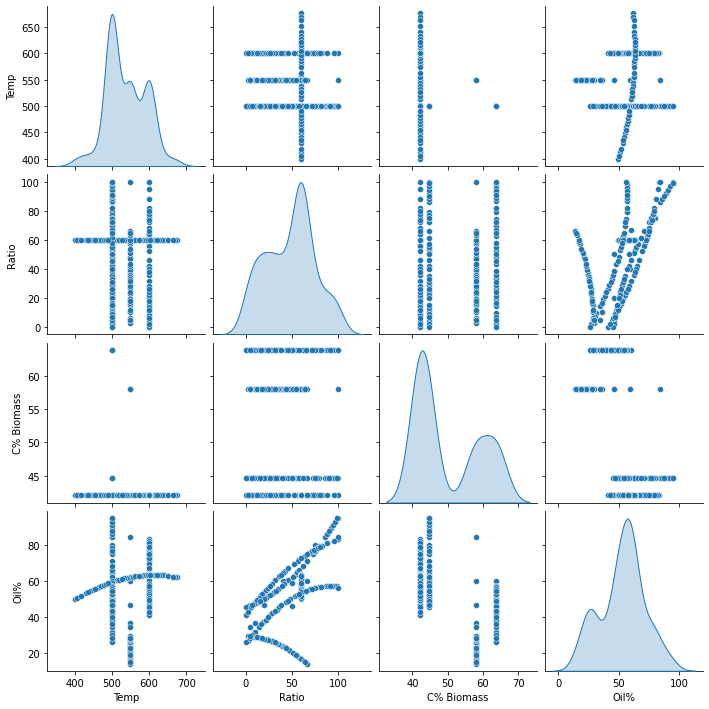

In [10]:
sns.pairplot(train_dataset[['Temp', 'Ratio', 'C% Biomass', 'Oil%']], diag_kind='kde')

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
C% Biomass,198.0,49.915606,9.069800,42.070000,42.070000,44.600000,58.000000,63.850000
H% Biomass,198.0,6.482828,1.104356,5.600000,5.600000,6.300000,6.400000,8.600000
O% Biomass,198.0,38.452929,18.463506,3.740000,34.000000,49.000000,52.010000,52.010000
N% Biomass,198.0,0.633283,0.870448,0.000000,0.260000,0.260000,0.330000,2.400000
C% HDPE,198.0,52.040707,41.620466,0.000000,0.000000,84.890000,84.890000,85.720000
H% HDPE,198.0,8.689394,6.949388,0.000000,0.000000,14.190000,14.190000,14.280000
O% HDPE,198.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
N% HDPE,198.0,0.157374,0.187652,0.000000,0.000000,0.000000,0.380000,0.380000
C% PS,198.0,35.231313,44.277446,0.000000,0.000000,0.000000,90.200000,91.000000
H% PS,198.0,3.363131,4.227635,0.000000,0.000000,0.000000,8.500000,8.800000


In [12]:
#Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.
train_features = train_dataset.copy()
test_features = test_dataset.copy()


train_labels = train_features.iloc[:, 16:].values
train_features = train_features.iloc[:, :16].values

test_labels = test_features.iloc[:, 16:].values

test_features = test_features.iloc[:, :16].values

In [13]:
#In the table of statistics it's easy to see how different the ranges of each feature are.
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
C% Biomass,49.915606,9.069800
H% Biomass,6.482828,1.104356
O% Biomass,38.452929,18.463506
N% Biomass,0.633283,0.870448
C% HDPE,52.040707,41.620466
H% HDPE,8.689394,6.949388
O% HDPE,0.000000,0.000000
N% HDPE,0.157374,0.187652
C% PS,35.231313,44.277446
H% PS,3.363131,4.227635


# Data Normalization


In [14]:

normalizer = preprocessing.Normalization()

normalizer.adapt(np.array(train_features))

print(normalizer.mean.numpy())

print(type(normalizer))


[ 49.916   6.483  38.453   0.633  52.041   8.689   0.      0.157  35.231
   3.363   0.314   0.      6.364  25.303  47.97  537.303]
<class 'tensorflow.python.keras.layers.preprocessing.normalization.Normalization'>


# Keras Sequential Model


In [15]:
def build_and_compile_model_0(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(3, activation='linear')
  ])

    model.compile(loss=['mean_absolute_error'], optimizer=tf.keras.optimizers.Adam(0.001),metrics=[keras.metrics.MeanAbsoluteError()]
    )
    return model
    
Name = 'ANN multioutputs regression '+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
Tensor_Board = keras.callbacks.TensorBoard(
    log_dir="../Model_0/Name/{}".format(Name),
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

In [16]:
dnn_model = build_and_compile_model_0(normalizer)

In [37]:
#dnn_model.summary()

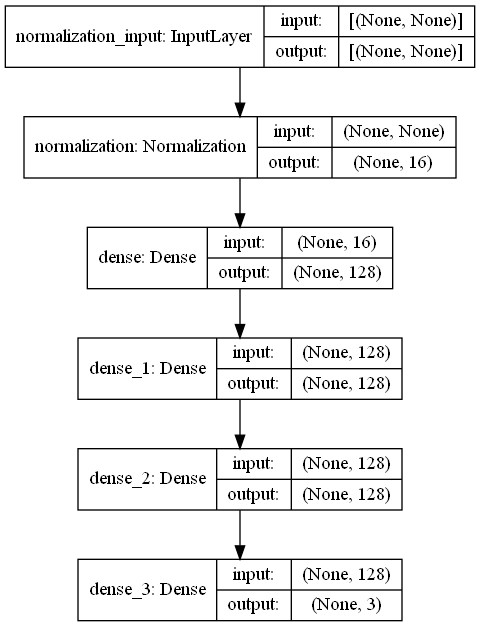

In [17]:
keras.utils.plot_model(dnn_model, "multi_input_and_output_model.png", show_shapes=True)


In [18]:
%%time
history = dnn_model.fit(train_features, y=(train_labels), batch_size=64, epochs=500, callbacks= Tensor_Board,validation_split=0.1)


Epoch 1/500
3/3 [==============================] - 2s 652ms/step - loss: 31.2971 - mean_absolute_error: 31.2971 - val_loss: 32.3331 - val_mean_absolute_error: 32.3331
Epoch 2/500
3/3 [==============================] - 0s 74ms/step - loss: 31.2021 - mean_absolute_error: 31.2021 - val_loss: 31.9748 - val_mean_absolute_error: 31.9748
Epoch 3/500
3/3 [==============================] - 0s 147ms/step - loss: 31.0159 - mean_absolute_error: 31.0159 - val_loss: 31.5060 - val_mean_absolute_error: 31.5060
Epoch 4/500
3/3 [==============================] - 0s 150ms/step - loss: 30.1009 - mean_absolute_error: 30.1009 - val_loss: 30.8769 - val_mean_absolute_error: 30.8769
Epoch 5/500
3/3 [==============================] - 0s 96ms/step - loss: 29.4468 - mean_absolute_error: 29.4468 - val_loss: 30.0070 - val_mean_absolute_error: 30.0070
Epoch 6/500
3/3 [==============================] - 0s 99ms/step - loss: 28.4414 - mean_absolute_error: 28.4414 - val_loss: 28.8172 - val_mean_absolute_error: 28.8172
E

# Model Evaluation

None


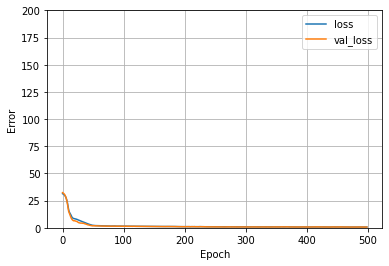

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 200])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
print(plot_loss(history))

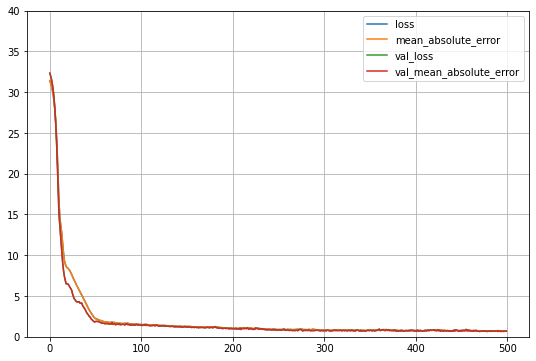

In [20]:
pd.DataFrame(history.history).plot(figsize=(9, 6))
plt.grid(True)
plt.gca().set_ylim(0, 40) 
plt.show()

In [21]:
dnn_model.evaluate(test_features, y=test_labels, verbose=0)

[0.4023240804672241, 0.4023240804672241]

In [22]:
y_pred = dnn_model.predict(test_features)

mse_one = mean_squared_error(test_labels[:,0], y_pred[:,0])
mse_two = mean_squared_error(test_labels[:,1], y_pred[:,1])
mse_three = mean_squared_error(test_labels[:,2], y_pred[:,2])
print(f'MSE for first regressor: {mse_one} - second regressor: {mse_two}- Third regressor: {mse_three}')
mae_one = mean_absolute_error(test_labels[:,0], y_pred[:,0])
mae_two = mean_absolute_error(test_labels[:,1], y_pred[:,1])
mae_three = mean_absolute_error(test_labels[:,2], y_pred[:,2])
print(f'MAE for first regressor: {mae_one} - second regressor: {mae_two}- second regressor: {mae_three}')


MSE for first regressor: 0.829273588622829 - second regressor: 0.3866488176662684- Third regressor: 0.3613185688769055
MAE for first regressor: 0.5428584123234211 - second regressor: 0.3189007004608651- second regressor: 0.34521333103774715


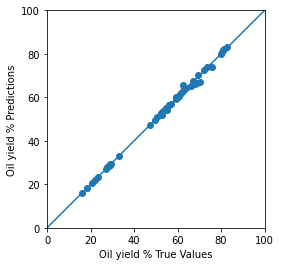

In [23]:
Pred_oil = y_pred[:,0]
test_oil = test_labels[:,0]
Pred_char = y_pred[:,1]
test_char = test_labels[:,1]
Pred_gas = y_pred[:,2]
test_gas = test_labels[:,2]


a = plt.axes(aspect='equal')
plt.scatter(test_oil, Pred_oil)
plt.xlabel('Oil yield % True Values')
plt.ylabel('Oil yield % Predictions')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


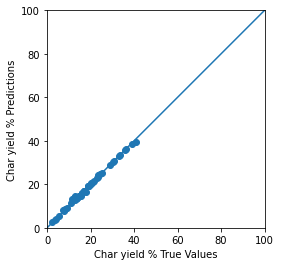

In [25]:
a = plt.axes(aspect='equal')
plt.scatter(test_char, Pred_char)
plt.xlabel('Char yield % True Values')
plt.ylabel('Char yield % Predictions')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

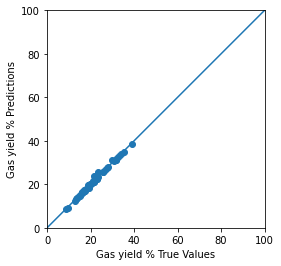

In [24]:
a = plt.axes(aspect='equal')
plt.scatter(test_gas, Pred_gas)
plt.xlabel('Gas yield % True Values')
plt.ylabel('Gas yield % Predictions')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [25]:
#Save the model 
#dnn_model.save('my_model.h5')
#To restore the model use: dnn_model = tf.keras.models.load_model('my_model.h5')